## Death-Slot analysis - draw positions semi-finals

In [1]:
import pandas as pd, numpy as np, seaborn as sbn, matplotlib.pyplot as plt

from Modules import utils as utl
from Modules import data_exploration as de
from Modules import machine_learning as ml

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

In [3]:
from scipy.stats import zscore
from scipy.stats import ttest_ind

#### Load cleaned CSV file and verify/ensure numeric draw positions

In [7]:
csv_semis_path = 'Data/semifinalists_cleaned.csv'

In [9]:
semis_df = utl.load_csv(csv_semis_path, skiprows=0, encoding='windows-1252')

In [23]:
# Identify null values. So long as we don't find any in semi_place, semi_draw_position or year, we can continue without further data cleaning
semis_df.isna().sum()

year                      0
semi_final                0
semi_draw_position        0
country                   0
style                     0
semi_place                0
semi_televote_points    240
semi_jury_points        271
semi_total_points         0
dtype: int64

In [13]:
# Quick check to see if the 3 features we need are in fact numeric
semis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   year                  483 non-null    int64  
 1   semi_final            483 non-null    int64  
 2   semi_draw_position    483 non-null    int64  
 3   country               483 non-null    object 
 4   style                 483 non-null    object 
 5   semi_place            483 non-null    float64
 6   semi_televote_points  243 non-null    float64
 7   semi_jury_points      212 non-null    float64
 8   semi_total_points     483 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 34.1+ KB


#### EDA (Exploratory Data Analysis) - Does any position stand out?

In [25]:
# Group draw position and semi place and calculate count, mean, median and standard variation for all draw positions
draw_position_stats_semis = semis_df.groupby('semi_draw_position')['semi_place'].agg(['count', 'mean', 'median', 'std']).sort_index()

In [29]:
# See the results
draw_position_stats_semis

,count,mean,median,std
semi_draw_position,,,,
1,26,9.769231,10.0,4.893324
2,28,11.714286,11.5,4.026368
3,28,11.892857,14.0,5.335689
4,28,10.071429,10.5,4.429937
5,28,10.000000,10.5,4.883836
6,28,8.392857,7.5,5.397800
7,28,9.000000,10.0,4.853407
8,28,8.821429,8.5,4.830870
9,28,8.178571,8.0,5.149999


In [31]:
# Filter out draw positions 18 and 19 due to too few observations
# It would have negatively impacted the rest of our analysis
semis_df = semis_df[semis_df['semi_draw_position'] <= 17]

In [44]:
# Repeat without 18th and 19th positions
draw_position_stats_semis = semis_df.groupby('semi_draw_position')['semi_place'].agg(['count', 'mean', 'median', 'std']).sort_index()

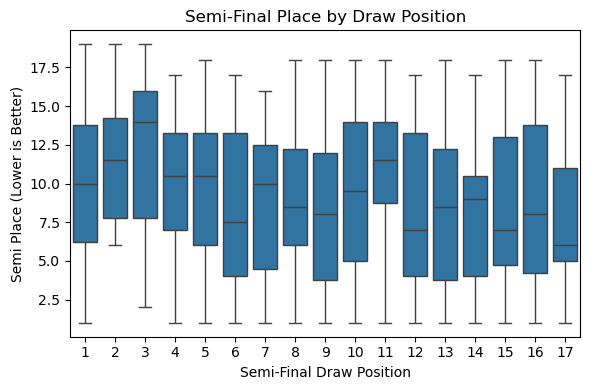

In [33]:
# Create a boxplot to see if there are any outliers and visualize our data
de.vs.boxplot(data=semis_df, x='semi_draw_position', y='semi_place', title='Semi-Final Place by Draw Position', 
              xlabel='Semi-Final Draw Position', ylabel='Semi Place (Lower is Better)')

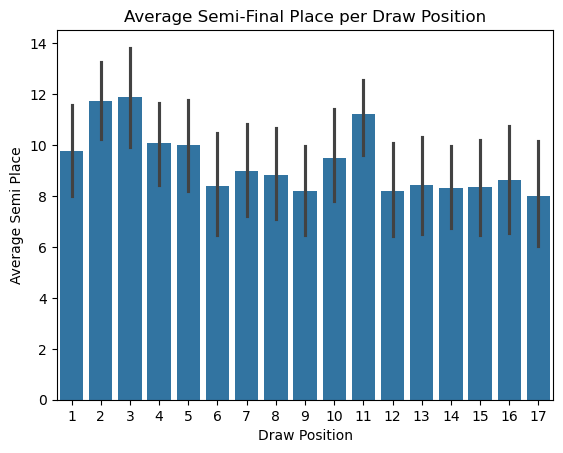

In [35]:
# Create a barplot to visualize overall performance of each position as well as the standard error
de.vs.barplot(semis_df, x_col='semi_draw_position', y_col='semi_place', agg_func='mean', 
              title='Average Semi-Final Place per Draw Position', 
              xlabel='Draw Position', ylabel='Average Semi Place')

##### From our draw position stats and our boxplot and barplot we now see the following:
- On average the mean of the 17 draw positions seem to be higher early on and drop off towards the last half - the exception being 11th position.
- The median appears higher in the earlier entries and gradually dropping towards the latter half of the semi-finals.
- The STD (standard deviation) across our 17 draw positions seem quite consistent between 4.02 & 5.59.

The boxplot shows that interestingly there's a fair amount of consistency. Both in terms of maximum and minimum data values but also the medians. The most obvious exceptions are the 2nd and 11th draw positions. We can see that 2nd position has an unusually high minimum data value while 11th position has rather narrow high and low quartile values.
The 3rd and 17th positions are also a little interesting in that, the former has the median and the latter has the lowest.

The barplot shows us the overall performance of each draw position, and it's clear that 2nd, 3rd and 11th positions have the 'worst' (mean/average) performance with roughly equal standard errors. At the same time we see that draw positions 6, 9 and 17 appear to be the, on average, best performing draw positions. 

#### Attempt at testing our hypothesis and use z-scores
That there is/are certain positions that are noticeably more favourable than others.

In [46]:
# Extracts the mean values for each draw position from our previous calculation
# Calculates the z_scores of the mean values
draw_position_means_semis = draw_position_stats_semis['mean']
z_scores_semis = zscore(draw_position_means_semis)

In [48]:
z_scores_semis

semi_draw_position
1     0.361517
2     1.937476
3     2.082162
4     0.606370
5     0.548496
6    -0.753674
7    -0.261743
8    -0.406429
9    -0.927297
10    0.143376
11    1.532357
12   -0.898360
13   -0.724737
14   -0.811548
15   -0.782611
16   -0.573374
17   -1.071982
Name: mean, dtype: float64

##### Computing z-scores of the mean semi place for each draw position to see if any stands out.
- 2nd draw position having a z-score of 1.937 it means that the average semi place of entries starting at position 2 are just below 2 standrad deviations worse than the overall average of all positions.
- 3rd draw position having a z-score of 2.082 it means that the average semi place of entries starting at position 3 are over 2 standrad deviations worse than the overall average of all positions.
- 11th draw position having a z-score of 1.532 it means that the average semi place of entries starting at position 11 are 1.5 standrad deviations worse than the overall average of all positions.
With 1.96 typically being enough to be considered statistically "extreme", we have exceeded this number once. This means we can technically say that 3rd draw position is an outlier by itself. No other draw positions has a higher z-score than position 3, albeit 2 is close. Interestingly, we do see that positions 9 and 17 have z-scores of -0.927 and 1.071 seemingly making them the best draw positions to have.

In [59]:
# Worth investigating further are 2nd and 3rd positions
position_2_semis = semis_df[semis_df['semi_draw_position'] == 2]['semi_place']
other_positions_than_2_semis = semis_df[semis_df['semi_draw_position'] != 2]['semi_place']
position_3_semis = semis_df[semis_df['semi_draw_position'] == 3]['semi_place']
other_positions_than_3_semis = semis_df[semis_df['semi_draw_position'] != 3]['semi_place']

In [61]:
# A 2 sample t-test (semi place for position X - sample1, semi place for all other positions - sample2)
# equal_var=False means we are doing a Welch's t-test. Taking into account that sample2 is larger than sample1, and that variability might differ
# t_stat is a measure of the difference between sample means relative to variance
# p_val is the probability that any observed differences are simply due to chance/randomness
t_stat_2, p_val_2 = ttest_ind(position_2_semis, other_positions_than_2_semis, equal_var=False)
t_stat_3, p_val_3 = ttest_ind(position_3_semis, other_positions_than_3_semis, equal_var=False)
print(f"T-statistic - 2nd draw: {t_stat_2}, p-value: {p_val_2}")
print(f"T-statistic - 3rd draw: {t_stat_3}, p-value: {p_val_3}")

T-statistic - 2nd draw: 3.1593136143696214, p-value: 0.00339650778730617
T-statistic - 3rd draw: 2.617972553150448, p-value: 0.013716697446592225


##### T-Test of position 2 and 3
Using Welch's t-test, comparing position 2 and 3 versus all other draw positions, we get a p-values of just 0.003 and 0.013, plus t-statistics of 3.159 and 2.617. 
The t-statistics indicate that the difference between the mean semi placements of the two groups (X place vs rest of data) is approx. 3.15 and 2.61 standard errors apart respectively, which is strong evidence of a meaningful difference for both placements. 
Our result when comparing position 2 and 3 to all other positions combined, is that we observe worse average placement for postion 2 and 3. This must be taken with a slight grain of salt however as we are comparing with entries from all other positions - creating an imbalance. However, these scores are still significant enough that even compared against a field of positions, that we can say they are worse draw positions.

The p-values are low. Our hypothesis being that starting at 2nd draw position/some positions are noticeably better/worse than others, this means our null hypothesis is that there is no difference. If the p-value is smaller than 0.05 that's ordinarily enough to reject the null hypothesis. 
For 2nd position we can reject our null hypothesis.
For 3rd position we cannot.